# Accessibility Simulations

> Inspired by Suh Young Choi.

In this section, we will be simulating different types of vision deficiencies: **color blindness** (color vision deficiency) and **blurred vision** (such as near-sightedness or far-sightedness). In the United States, color blindness affects about 1 in 12 men and about 1 in 200 women while blurred vision affects about 1 in 3 people. We can help design more accessible visualizations by simulating different kinds of vision deficiencies using computer vision techniques.

In [19]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

plot = iio.imread("plot.png", mode="RGB")

def compare(*images):
    """Display one or more images side by side."""
    _, axs = plt.subplots(1, len(images), figsize=(15, 6))
    for ax, image in zip(axs, images):
        ax.imshow(image, cmap="gray")
        ax.set_axis_off()
    plt.show()

## Simulating Monochromatism

*Monochromatism* (also called *achromatopsia*) is the rarest form of color vision deficiency, in which an individual has total color blindness. In other words, they see everything in grayscale.

Write a function `grayscale` that takes an RGB image and returns a new, single-channel grayscale image with the **weighted average** of the color channels:

1. Multiply every value in the **red** channel by 0.3
1. Multiply every value in the **green** channel by 0.586
1. Multiply every value in the **blue** channel by 0.114
1. Add the new red, green, and blue color values for each pixel in the image as a single-channel, grayscale image.

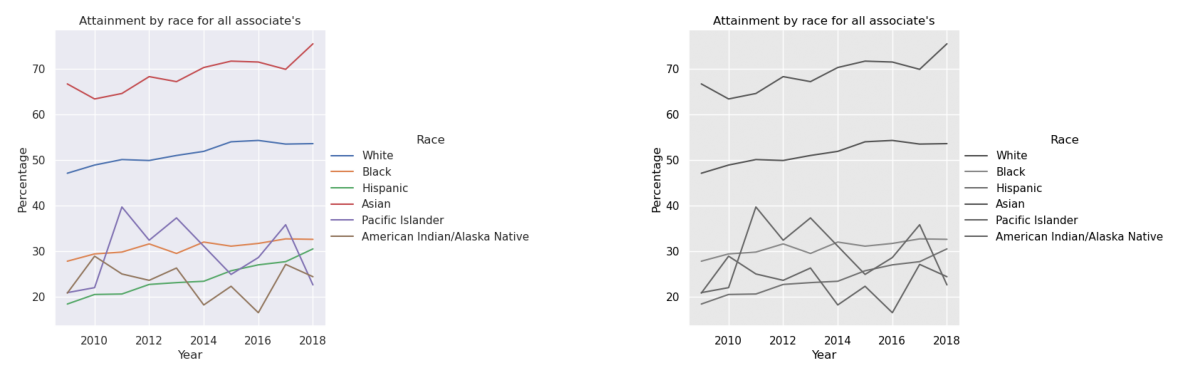

In [20]:
def grayscale(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    result = r *0.3 + g*0.586 + b*0.114
    return result.clip(0, 255).astype("uint8")


compare(plot, grayscale(plot))

## Simulating Protanopia

*Protanopia* (pro-tuh-NOPE-ee-uh), also known as red-blindness, is a form of color vision deficiency for red light. A person with protanopia has cones that are less sensitive to red light.

Write a function `protanopia` that takes an RGB image and returns a new image with color values weighted according to the formula:

$$
\begin{aligned}
r_{new} &=& 0.15R + 1.05G - 0.2B \\
g_{new} &=& 0.11R + 0.79G + 0.1B \\
b_{new} &=&    0R  -0.05G + 1.05B
\end{aligned}
$$

`np.stack` can be used to recombine separated RGB color channels back into a image with the argument `axis=-1` to "stack" the channels along a new, last dimension.

```py
np.stack([r, g, b], axis=-1)
```

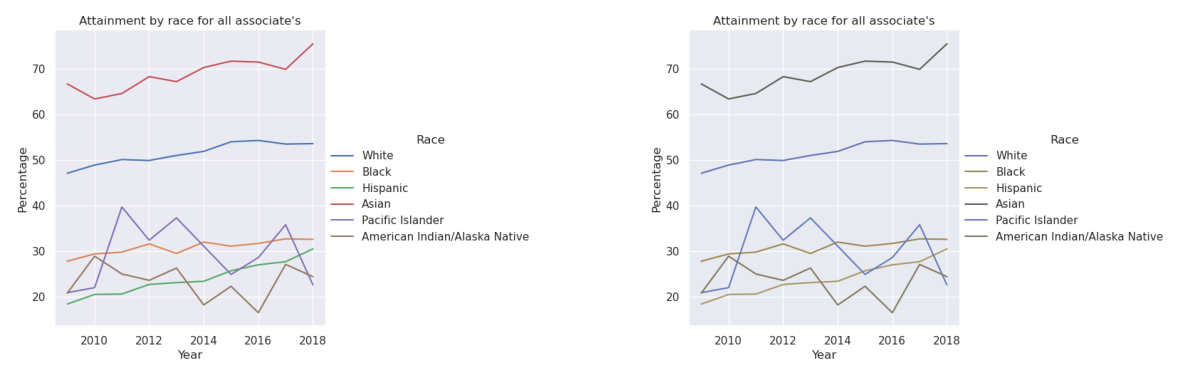

In [21]:
def protanopia(image):
    """Adjusts the color values of an image to simulate protanopia"""
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return np.stack([
        0.15 * r + 1.05 * g - 0.2 * b,
        0.11 * r + 0.79 * g + 0.1 * b,
        0 * r - 0.05 * g + 1.05 * b,
    ], axis=-1).clip(0, 255).astype("uint8")


compare(plot, protanopia(plot))

## Simulating Deuteranopia

Another type of color vision deficiency is called *deuteranopia* (doo-ter-uh-NOPE-ee-uh), or green-blindness. A person with deuteranopia has cones that are less sensitive to green light. Deuteranopia and protanopia are often grouped together under the umbrella term of red-green blindness, since people with either color vision deficiency have difficulty differentiating red and green values. The simulation for deuteranopia will appear very similar to the simulation for protanopia.

To simulate deuteranopia, write a function `reweight` that takes an image as well as 3 lists of weights for RGB values and returns a new image with color values reweighted accordingly. The `deuteranopia` function then calls `reweight` with the RGB weights for simulating deuteranopia.

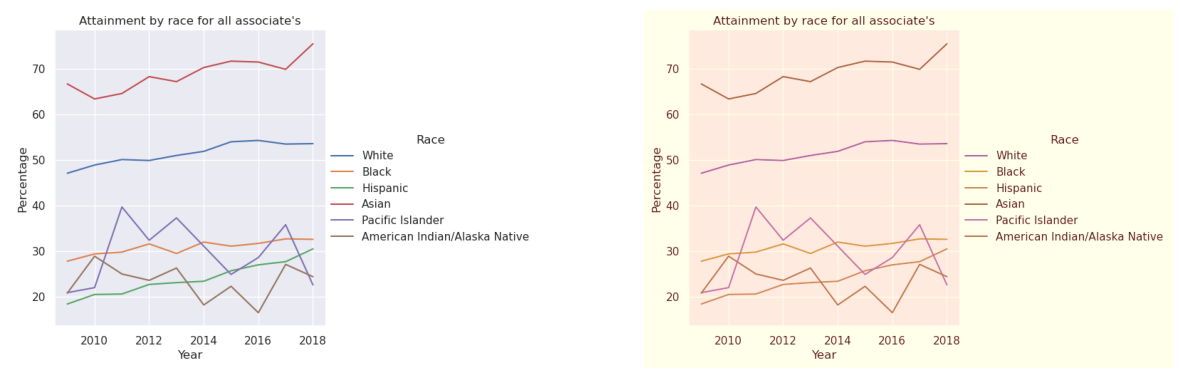

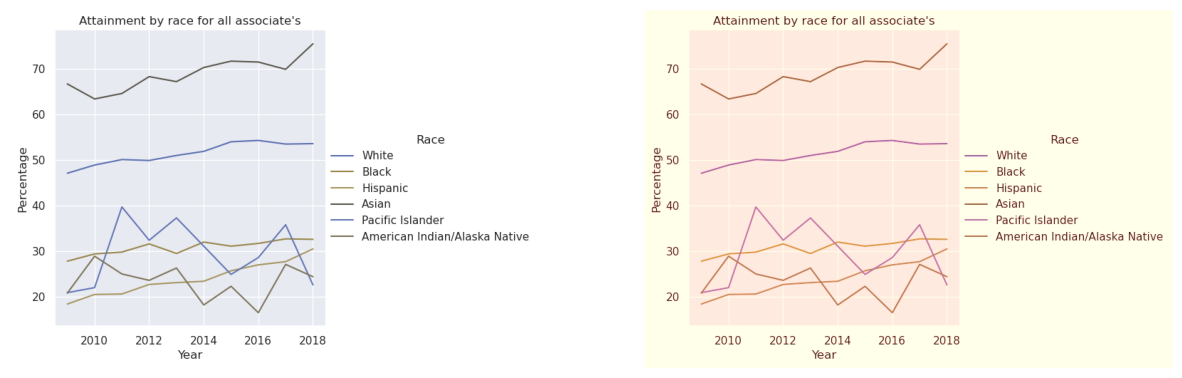

In [22]:
def reweight(image, r_new, g_new, b_new):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return np.stack([
        r_new[0] * r + r_new[1] * g - r_new[2] * b,
        g_new[0] * r + g_new[1] * g + g_new[2] * b,
        b_new[0] * r - b_new[1] * g + b_new[2] * b
    ], axis=-1).clip(0, 255).astype("uint8")


def deuteranopia(image):
    return reweight(
        image,
        [ 0.36, 0.86, -0.22],
        [ 0.28, 0.67,  0.05],
        [-0.01, 0.04,  0.97],
    )


compare(plot, deuteranopia(plot))
compare(protanopia(plot), deuteranopia(plot))

## Simulating Tritanopia

The final type of color vision deficiency we'll simulate is *tritanopia* (try-tuh-NOPE-ee-uh), or blue-blindness. A person with tritanopia has cones that are less sensitive to blue light. The simulation for tritanopia will appear quite different from the simulations for deuteranopia and protanopia.

Write a function `tritanopia` that takes an RGB image and returns a new image with color values weighted according to the formula:

$$
\begin{aligned}
r_{new} &=&  1.26R - 0.08G - 0.18B \\
g_{new} &=& -0.08R + 0.93G + 0.15B \\
b_{new} &=&  0R + 0.7G + 0.3B
\end{aligned}
$$

Call the `reweight` function in your implementation.

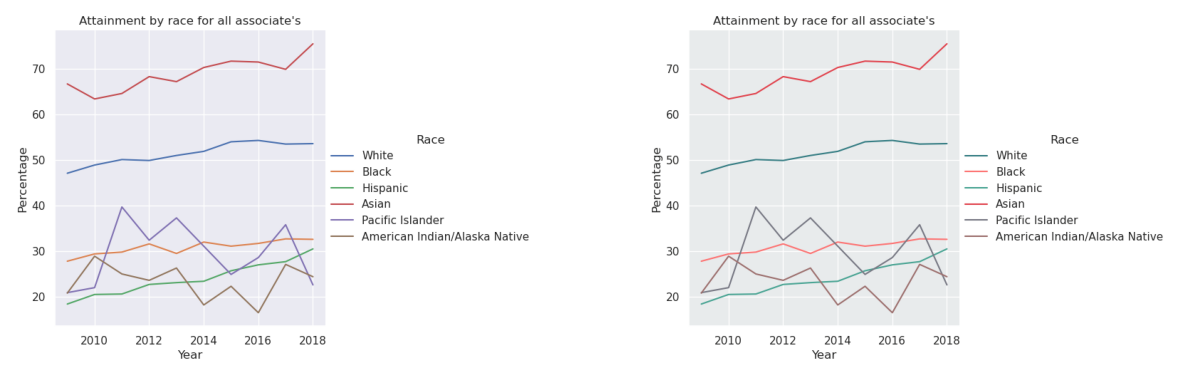

In [23]:
def tritanopia(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return np.stack([
        1.26 * r - 0.08 * g - 0.18 * b,
        -0.08 * r + 0.93 * g + 0.15 * b,
        0 * r + 0.7 * g + 0.3 * b,
    ], axis=-1).clip(0, 255).astype("uint8")


compare(plot, tritanopia(plot))

## Simulating Blurred Vision

In lecture, we learned how to apply convolution to blur a grayscale image. Let's learn how to use convolutions to blur RGB images.

Write a function `box_blur` that takes an RGB image and a kernel size and returns the result of applying the specified amount of box blur to the image. The provided convolution code works for grayscale images, but doesn't work for RGB images due to broadcasting errors. Fix the broadcasting error.

In [24]:
def box_blur(image, kernel_size):
    # Prepare result shape
    image_height, image_width, image_channels = image.shape
    result = np.zeros((image_height - kernel_size + 1, image_width - kernel_size + 1, image_channels))
    result_height, result_width, result_channels = result.shape

    # Setup the box blur kernel as a 2-dimensional square array
    kernel = np.array([1 / (kernel_size ** 2)] * (kernel_size ** 2)).reshape((kernel_size, kernel_size))
    display(kernel.round(3))

    # Apply the kernel via convolution to every subimage
    for i in range(result_height):
        for j in range(result_width):
            subimage = image[i:i + kernel_size, j:j + kernel_size]
            result[i, j] = np.sum(subimage * kernel)

    return result.clip(0, 255).astype("uint8")


compare(plot, box_blur(plot, 9)) # Try changing the kernel size

array([[0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012],
       [0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012]])

ValueError: operands could not be broadcast together with shapes (9,9,3) (9,9) 

Another way to simulate blurred vision is **gaussian blur**, which uses a gaussian kernel.

First, apply your broadcasting fix by copying your code from the previous `box_blur` function over to the `gaussian_blur` function.

Then, write a function `gaussian_kernel` that takes two parameters `n` and `sigma` and returns the `n`-by-`n` gaussian blur kernel, where each element is defined as:

$$
kernel[i, j] = e^{\frac{-(i-\frac{n}{2})^2 + (j-\frac{n}{2})^2}{2\sigma^2}}
$$

Call `np.exp(...)` for $e^{(...)}$. When implementing $\frac{n}{2}$, use floor division by writing `//` instead of `/` to ensure the resulting kernel will be symmetric.

In [ ]:
def gaussian_kernel(n, sigma):
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = ...
    return kernel / np.sum(kernel)


def gaussian_blur(image, kernel_size, smoothing_factor):
    # Prepare result shape
    image_height, image_width, image_channels = image.shape
    result = np.zeros((image_height - kernel_size + 1, image_width - kernel_size + 1, image_channels))
    result_height, result_width, result_channels = result.shape

    # Setup the box blur kernel as a 2-dimensional square array
    kernel = gaussian_kernel(kernel_size, smoothing_factor)
    display(kernel.round(3))

    # Apply the kernel via convolution to every subimage
    for i in range(result_height):
        for j in range(result_width):
            subimage = image[i:i + kernel_size, j:j + kernel_size]
            result[i, j] = np.sum(subimage * kernel)

    return result.clip(0, 255).astype("uint8")


compare(plot, gaussian_blur(plot, 9, 1)) # Try changing the kernel size and smoothing factor

## Making visualizations accessible to screen readers

Beyond simulating color blindness and blurred vision, millions of Americans use screen readers: apps that read the contents of a computer screen aloud (using a generated voice) or Braille. However, visualizations are often inaccessible to screen readers. This is especially the case for visualizations represented as images, but UW researchers have studied how interactive visualizations can be made more accessible as part of the [VoxLens project](https://www.washington.edu/news/2022/06/01/voxlens-adding-one-line-of-code-can-make-some-interactive-visualizations-accessible-to-screen-reader-users/).

For visualizations represented as images, adding alternative text (alt text) is one way to help screen readers understand the purpose and information communicated by a visualization. A longer description should typically be made available in the surrounding text as well to give context to the image for all readers. Amy Cesal provides guidance on [Writing Alt Text for Data Visualization](https://nightingaledvs.com/writing-alt-text-for-data-visualization/).

In Markdown cells, alt text can be included when embedding an image by writing text within the square brackets:

```md
![...](plot.png)
```

Edit the following cell to add a descriptive alt text in the format, "**Chart type** of **type of data** where **reason for including chart**" (replacing bolded text appropriately).

![](plot.png)